# Horizontal scaling of columnar analysis: Dask

(no frills notebook)

<br><br><br><br><br>

There are many ways to spread a computation to many processes or many machines—the most conventional way is to use a batch system.

[Coffea](https://coffeateam.github.io/coffea/) packages up a lot of what I'm about to show in a HEP-oriented framework. The next major version, based on dask-awkward, is [still in pre-release](https://pypi.org/project/coffea/#history) but will be in final release soon.

This notebook will focus on Dask and dask-awkward.

## General introduction to Dask

In [1]:
import dask

Eager Python code:

In [2]:
def increment(i):
    return i + 1

def add(a, b):
    return a + b

a, b = 1, 12
c = increment(a)
d = increment(b)
output = add(c, d)

output

15

Lazy Python code:

In [3]:
@dask.delayed
def increment(i):
    return i + 1

@dask.delayed
def add(a, b):
    return a + b

a, b = 1, 12
c = increment(a)
d = increment(b)
output = add(c, d)

output

Delayed('add-86bf2317-7f50-44cb-acc9-117aa305e6eb')

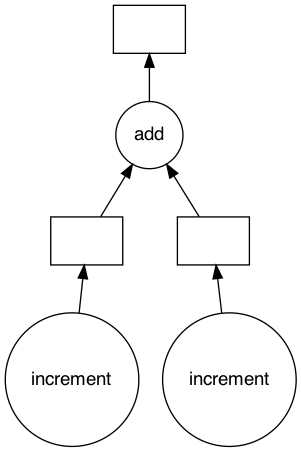

In [4]:
output.visualize()

In [5]:
output.compute()

15

<br><br><br><br><br>

A delayed computation is a set of instructions to run it, which we can send to remote computers to run it remotely.

When we break up a large computation, send it to many computers, and collect the results, we have distributed the computation.

In [22]:
import time

@dask.delayed
def start():
    print("start")
    return 1

@dask.delayed
def concurrent(initial, i):
    time.sleep(0.5)
    print(f"concurrent {i}")
    return initial + i**2

@dask.delayed
def combine(partial_results):
    print("combine")
    return sum(partial_results)

initial = start()
output = combine([concurrent(initial, i) for i in range(10)])

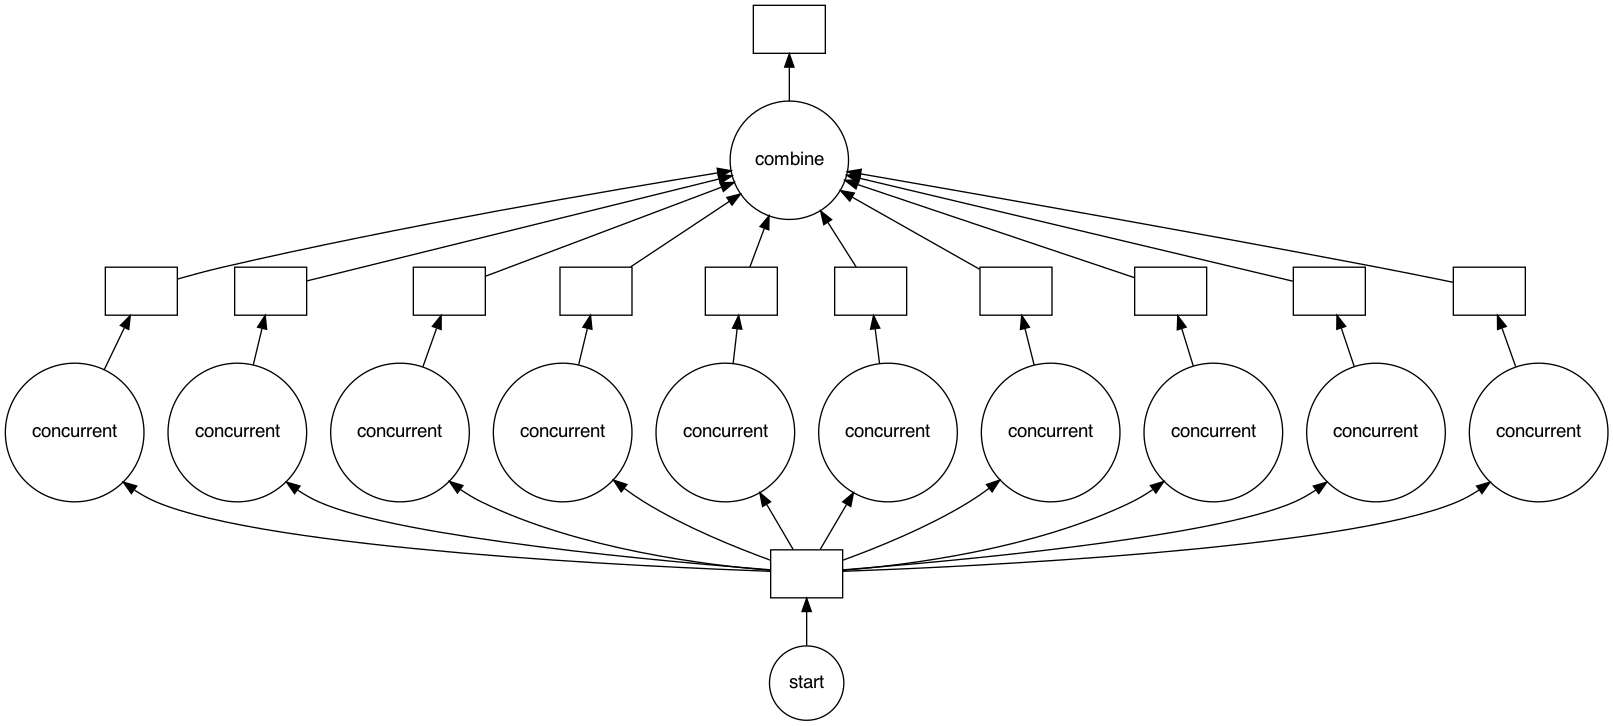

In [23]:
output.visualize()

The `dask` library has three built-in schedulers:

- `"synchronous"`: not parallel (for debugging)
- `"threads"`: multiple threads in the same process, limited by the [Python GIL](https://realpython.com/python-gil/)
- `"processes"`: multiple Python processes; not affected by the GIL, but it has to start a bunch of processes

In [30]:
with dask.config.set(scheduler="synchronous"):
    output.compute()

start
concurrent 8
concurrent 5
concurrent 2
concurrent 3
concurrent 9
concurrent 0
concurrent 1
concurrent 7
concurrent 4
concurrent 6
combine


Dask `distributed` is another library that focuses on distributed computing.

<img src="img/distributed-overview.svg" width="100%">

Run in a terminal:

```bash
dask-scheduler &
dask-worker --nthreads 4 127.0.0.1:8786 &
```